In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np
from nff.io.ase_calcs import NeuralFF

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

/home/dux/NeuralForceField/models


Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3_001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/SrTiO3_001/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

19:50:27 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
19:50:27 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

19:50:27 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3_001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
19:50:27 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
19:50:27 - mcmc.system | INFO: Initializing 64 virtual atoms
19:50:27 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19:50:27 - mcmc.system | INFO: Number of pristine atoms is 60
19:50:27 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
19:50:27 - mcmc.

      Step     Time          Energy          fmax
BFGS:    0 19:50:28     -467.521881        0.204407
BFGS:    1 19:50:28     -467.525757        0.180273
BFGS:    2 19:50:28     -467.540619        0.079327
BFGS:    3 19:50:29     -467.540924        0.059827
BFGS:    4 19:50:29     -467.541351        0.005864


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

19:50:30 - mcmc.mcmc | INFO: Using run folder SrTiO3_001
19:50:30 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
19:50:30 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
19:50:30 - mcmc.mcmc | INFO: Starting with iteration 0
19:50:30 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
19:50:30 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:50:30     -466.868744       10.891214
BFGS:    1 19:50:30     -468.307098        6.987189
BFGS:    2 19:50:31     -469.367950        3.150189
BFGS:    3 19:50:31     -469.803741        1.445371
BFGS:    4 19:50:32     -469.970703        1.355825
BFGS:    5 19:50:32     -470.191040        1.767895
BFGS:    6 19:50:33     -470.334808        2.104822
BFGS:    7 19:50:33     -470.671661        2.671716
BFGS:    8 19:50:34     -470.650970        2.842388
BFGS:    9 19:50:34     -470.892242        1.323507
BFGS:   10 19:50:34     -470.979645        1.317511
BFGS:   11 19:50:34     -471.288483        1.357580
BFGS:   12 19:50:35     -471.432129        1.046816
BFGS:   13 19:50:35     -471.476440        0.890574
BFGS:   14 19:50:36     -471.560028        0.645799
BFGS:   15 19:50:36     -471.581055        0.587881
BFGS:   16 19:50:36     -471.605804        0.437010
BFGS:   17 19:50:37     -471.615967        0.361694
BFGS:   18 19:

19:51:22 - mcmc.system | INFO: Optimized structure has Energy = 10.721
19:51:22 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:51:22     -469.715454       12.805318
BFGS:    1 19:51:23     -472.529694        7.252857
BFGS:    2 19:51:23     -474.549225        4.495608
BFGS:    3 19:51:23     -475.970215        2.382985
BFGS:    4 19:51:23     -476.943878        2.267819
BFGS:    5 19:51:24     -477.679810        2.448236
BFGS:    6 19:51:25     -478.261841        2.868309
BFGS:    7 19:51:25     -478.631256        6.346717
BFGS:    8 19:51:25     -479.405518        3.525722
BFGS:    9 19:51:26     -480.368011        3.175396
BFGS:   10 19:51:27     -480.754883        3.405954
BFGS:   11 19:51:27     -481.149933        3.839192
BFGS:   12 19:51:28     -481.681396        2.161505
BFGS:   13 19:51:28     -481.847931        1.716426
BFGS:   14 19:51:29     -481.989258        1.390547
BFGS:   15 19:51:30     -482.150604        1.196971
BFGS:   16 19:51:30     -482.282379        1.387204
BFGS:   17 19:51:30     -482.311615        2.657447
BFGS:   18 19:

19:52:12 - mcmc.system | INFO: Optimized structure has Energy = 10.721
19:52:12 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:52:12     -472.539673       11.154166
BFGS:    1 19:52:12     -475.214447        7.078129
BFGS:    2 19:52:13     -477.512299        3.344196
BFGS:    3 19:52:13     -478.901215        2.770978
BFGS:    4 19:52:14     -479.885101        2.456448
BFGS:    5 19:52:14     -480.471954        3.538296
BFGS:    6 19:52:15     -481.084015        3.684355
BFGS:    7 19:52:15     -482.264069        5.123358
BFGS:    8 19:52:16     -483.414642        3.230303
BFGS:    9 19:52:17     -484.146362        6.908371
BFGS:   10 19:52:17     -484.788239        6.879498
BFGS:   11 19:52:17     -485.641815        3.260395
BFGS:   12 19:52:18     -486.364502        2.272610
BFGS:   13 19:52:19     -486.924774        2.251482
BFGS:   14 19:52:19     -487.354645        2.597889
BFGS:   15 19:52:20     -487.628082        2.095453
BFGS:   16 19:52:20     -487.960205        1.346564
BFGS:   17 19:52:20     -488.047607        1.329600
BFGS:   18 19:

19:53:01 - mcmc.system | INFO: Optimized structure has Energy = 10.721
19:53:01 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:53:01     -472.999390       14.829167
BFGS:    1 19:53:02     -477.462524        8.539839
BFGS:    2 19:53:03     -480.320435        5.416974
BFGS:    3 19:53:03     -481.556305        5.030636
BFGS:    4 19:53:04     -481.925690        2.708474
BFGS:    5 19:53:05     -482.565430        2.317767
BFGS:    6 19:53:05     -482.877228        3.086658
BFGS:    7 19:53:06     -483.335846        3.921892
BFGS:    8 19:53:07     -483.734955        3.768060
BFGS:    9 19:53:08     -484.121124        2.233331
BFGS:   10 19:53:08     -484.377716        1.606819
BFGS:   11 19:53:09     -484.794098        2.529446
BFGS:   12 19:53:09     -485.264862        2.633058
BFGS:   13 19:53:09     -485.952240        4.190361
BFGS:   14 19:53:10     -486.536987        2.426683
BFGS:   15 19:53:10     -486.995514        1.970506
BFGS:   16 19:53:11     -487.320343        2.300687
BFGS:   17 19:53:11     -487.558319        2.182605
BFGS:   18 19:

19:53:52 - mcmc.system | INFO: Optimized structure has Energy = 10.721
19:53:52 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:53:52     -471.651123       14.472025
BFGS:    1 19:53:53     -476.952667        9.690383
BFGS:    2 19:53:53     -480.569244        7.392904
BFGS:    3 19:53:53     -482.903809        4.538479
BFGS:    4 19:53:53     -483.603516        6.566838
BFGS:    5 19:53:54     -484.214600        2.756922
BFGS:    6 19:53:54     -484.949921        1.745321
BFGS:    7 19:53:55     -485.082184        5.007991
BFGS:    8 19:53:55     -485.461639        2.561837
BFGS:    9 19:53:55     -485.654175        2.156516
BFGS:   10 19:53:56     -485.984283        2.596723
BFGS:   11 19:53:56     -486.114258        2.114599
BFGS:   12 19:53:56     -486.583740        1.104049
BFGS:   13 19:53:56     -486.859528        1.493855
BFGS:   14 19:53:56     -487.008636        1.500188
BFGS:   15 19:53:57     -487.412567        1.362117
BFGS:   16 19:53:57     -487.629913        1.603230
BFGS:   17 19:53:58     -487.859253        1.403718
BFGS:   18 19:

19:54:37 - mcmc.system | INFO: Optimized structure has Energy = 7.425
19:54:38 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:54:38     -450.487213       38.113569
BFGS:    1 19:54:38     -461.489899       19.445181
BFGS:    2 19:54:38     -468.423981       11.401699
BFGS:    3 19:54:38     -473.812347        7.154059
BFGS:    4 19:54:39     -477.438324        4.787567
BFGS:    5 19:54:39     -479.788208        3.075027
BFGS:    6 19:54:39     -481.315674        2.384982
BFGS:    7 19:54:40     -482.425018        2.892990
BFGS:    8 19:54:40     -483.353485        2.769950
BFGS:    9 19:54:40     -483.939117        2.782236
BFGS:   10 19:54:41     -484.566803        2.641501
BFGS:   11 19:54:41     -485.662018        2.782961
BFGS:   12 19:54:41     -486.092926        2.755720
BFGS:   13 19:54:42     -486.562012        2.414373
BFGS:   14 19:54:42     -487.007080        2.398953
BFGS:   15 19:54:43     -487.475189        2.058440
BFGS:   16 19:54:43     -487.751434        1.272060
BFGS:   17 19:54:43     -487.879608        1.346465
BFGS:   18 19:

19:55:18 - mcmc.system | INFO: Optimized structure has Energy = 3.777
19:55:18 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:55:18     -404.684418      150.837933
BFGS:    1 19:55:19     -444.089600       73.382306
BFGS:    2 19:55:19     -459.987061       49.282828
BFGS:    3 19:55:20     -473.946381       33.402018
BFGS:    4 19:55:20     -484.903687       17.702593
BFGS:    5 19:55:21     -490.941010       10.607885
BFGS:    6 19:55:22     -494.768463        6.676084
BFGS:    7 19:55:22     -497.110840        4.654534
BFGS:    8 19:55:22     -498.713043        3.410950
BFGS:    9 19:55:23     -500.033325        3.648206
BFGS:   10 19:55:23     -501.281738        4.365681
BFGS:   11 19:55:23     -502.404785        4.199837
BFGS:   12 19:55:24     -503.434540        3.270226
BFGS:   13 19:55:24     -504.381256        2.904186
BFGS:   14 19:55:24     -505.503418        2.520593
BFGS:   15 19:55:25     -506.463043        3.153906
BFGS:   16 19:55:25     -507.359863        3.188565
BFGS:   17 19:55:26     -507.862915        2.300616
BFGS:   18 19:

19:56:12 - mcmc.system | INFO: Optimized structure has Energy = 3.926
19:56:12 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:56:12     -413.306274      151.091769
BFGS:    1 19:56:13     -450.430023       73.693788
BFGS:    2 19:56:13     -462.587646       48.392492
BFGS:    3 19:56:14     -473.008209       33.194845
BFGS:    4 19:56:14     -481.959564       17.688920
BFGS:    5 19:56:15     -487.132233       10.913094
BFGS:    6 19:56:15     -490.301178        6.997711
BFGS:    7 19:56:16     -492.437256        4.779974
BFGS:    8 19:56:16     -494.010010        3.552887
BFGS:    9 19:56:16     -494.922516        3.944933
BFGS:   10 19:56:17     -495.854370        4.215389
BFGS:   11 19:56:17     -497.256134        4.610415
BFGS:   12 19:56:17     -498.165558        4.151962
BFGS:   13 19:56:17     -498.801483        3.769538
BFGS:   14 19:56:18     -499.658081        3.105330
BFGS:   15 19:56:18     -500.681244        2.180063
BFGS:   16 19:56:18     -501.399445        2.332274
BFGS:   17 19:56:19     -501.934235        1.579918
BFGS:   18 19:

19:56:44 - mcmc.system | INFO: Optimized structure has Energy = 1.710
19:56:44 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:56:44    34375.417969   815341.352377
BFGS:    1 19:56:45     -341.579681      385.269832
BFGS:    2 19:56:45     -396.375488      378.291492
BFGS:    3 19:56:45     -435.483795       61.505593
BFGS:    4 19:56:46     -441.206024       49.771595
BFGS:    5 19:56:46     -454.890533       73.173168
BFGS:    6 19:56:47     -466.822906       31.198567
BFGS:    7 19:56:47     -473.808258       15.784987
BFGS:    8 19:56:47     -479.330902       26.385612
BFGS:    9 19:56:48     -483.804443       22.573463
BFGS:   10 19:56:48     -487.166901        7.917704
BFGS:   11 19:56:48     -489.833954        8.643987
BFGS:   12 19:56:49     -491.960907       11.611631
BFGS:   13 19:56:49     -493.938385       10.518511
BFGS:   14 19:56:49     -495.436798        4.176037
BFGS:   15 19:56:49     -496.870483        4.604577
BFGS:   16 19:56:49     -498.048615        9.359786
BFGS:   17 19:56:49     -499.307098       10.294123
BFGS:   18 19:

19:57:04 - mcmc.system | INFO: Optimized structure has Energy = 2.219
19:57:04 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy          fmax
BFGS:    0 19:57:04    34416.265625   817319.722136
BFGS:    1 19:57:04     -289.122070     1665.285636
BFGS:    2 19:57:04     -396.899506      431.220850
BFGS:    3 19:57:04     -422.484406      429.714458
BFGS:    4 19:57:04     -436.616547      428.230352
BFGS:    5 19:57:05     -457.367310      188.109198
BFGS:    6 19:57:05     -464.614471       59.457445
BFGS:    7 19:57:05     -471.004181       65.643041
BFGS:    8 19:57:05     -474.557617       58.556578
BFGS:    9 19:57:05     -476.643646       75.645681
BFGS:   10 19:57:05     -480.069122       47.676356
BFGS:   11 19:57:05     -481.864258       30.924294
BFGS:   12 19:57:06     -483.055023        9.453341
BFGS:   13 19:57:06     -483.818329       26.532380
BFGS:   14 19:57:06     -484.563080       24.959079
BFGS:   15 19:57:06     -485.197876        8.956183
BFGS:   16 19:57:06     -486.014862       19.337008
BFGS:   17 19:57:06     -486.569794       34.747450
BFGS:   18 19:

19:57:23 - mcmc.system | INFO: Optimized structure has Energy = 2.268


Time taken = 413.540 seconds


Plot results

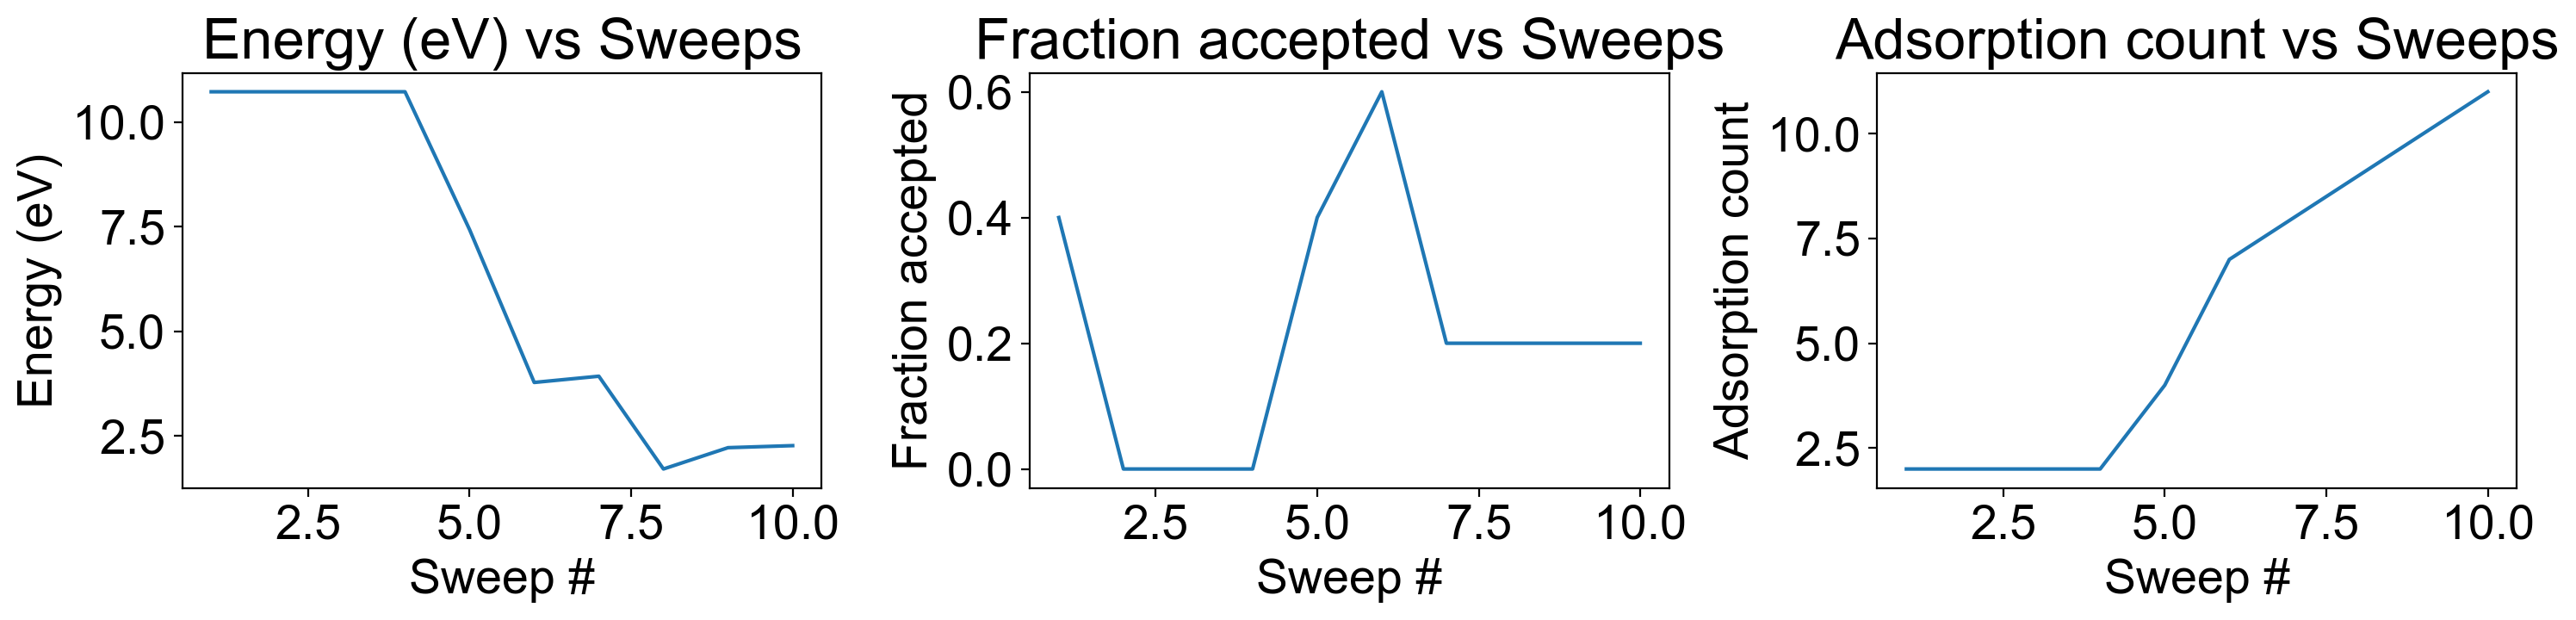

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)